# Run everything and compare to SSPs

In [1]:
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import pooch

/Users/c.l.b.alexander/Documents/FAIR/fair_virtual_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pl.rcParams['figure.figsize'] = (8.7/2.54, 8.7/2.54)
pl.rcParams['font.size'] = 7
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['ytick.direction'] = 'in'
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.direction'] = 'in'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['xtick.major.top'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['axes.spines.top'] = True
pl.rcParams['axes.spines.bottom'] = True
pl.rcParams['figure.dpi'] = 150

In [3]:
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
runs = [1, 2, 3, 4, 8]

In [4]:
temp_ukesm = np.ones((251, 4, 5)) * np.nan
for iscen, scenario in enumerate(scenarios):
    for irun, run in enumerate(runs):
        temp_ukesm[:165, iscen, irun] = pd.read_csv(f'../data/fredriksen2022/historical/UKESM1-0-LL_historical_r{run}i1p1f2_anomalies.txt', index_col=0)['tas'].values
        temp_ukesm[165:, iscen, irun] = pd.read_csv(f'../data/fredriksen2022/{scenario}/UKESM1-0-LL_{scenario}_r{run}i1p1f2_anomalies.txt', index_col=0)['tas'].values

In [5]:
climate_response_df = pd.read_csv('../data/fair-calibrations/4xCO2_energy_balance_ebm3.csv')

In [6]:
natural_forcing_df = pd.read_csv('../data/calibration/natural_forcing.csv', index_col=0)

In [7]:
f = FAIR()

In [8]:
configs = ['UKESM1-0-LL']#, 'hand_tune']
species, properties = read_properties(filename='../data/species_configs_properties_vanilla.csv')
species.remove('CO2 FFI')      # c-driven run
species.remove('CO2 AFOLU')    # c-driven run
species.remove('Halon-1202')   # not in CMIP6 list of species
species.remove('Contrails')    # not modelled in UKESM, I think
species.remove('NOx aviation') # which renders this redundant
species.remove('Light absorbing particles on snow and ice')  # I believe not modelled in UKESM
del properties['CO2 FFI']
del properties['CO2 AFOLU']
del properties['Halon-1202']
del properties['Contrails']
del properties['NOx aviation']
del properties['Light absorbing particles on snow and ice']
for specie in species:
    if properties[specie]['greenhouse_gas']:
        properties[specie]['input_mode'] = 'concentration'
properties['Land use']['input_mode'] = 'forcing'
properties

{'CO2': {'type': 'co2',
  'input_mode': 'concentration',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': False},
 'CH4': {'type': 'ch4',
  'input_mode': 'concentration',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': True},
 'N2O': {'type': 'n2o',
  'input_mode': 'concentration',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': True},
 'Sulfur': {'type': 'sulfur',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chemistry_from_emissions': True,
  'aerosol_chemistry_from_concentration': False},
 'BC': {'type': 'black carbon',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chemistry_from_emissions': True,
  'aerosol_chemistry_from_concentration': False},
 'OC': {'type': 'organic carbon',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chemi

In [9]:
f.define_time(1850, 2101, 1)
f.define_scenarios(scenarios)
f.define_configs(configs)
f.define_species(species, properties)

In [10]:
f.allocate()

In [11]:
fill(f.climate_configs['ocean_heat_capacity'], climate_response_df.loc[0, 'C1':'C3'])
fill(f.climate_configs['ocean_heat_transfer'], climate_response_df.loc[0, 'kappa1':'kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], climate_response_df.loc[0, 'epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], climate_response_df.loc[0, 'gamma'])

In [12]:
initialise(f.forcing, 0)
initialise(f.temperature, 0)

In [13]:
f.fill_species_configs(filename='../data/species_configs_properties_vanilla.csv')

In [14]:
f.fill_from_rcmip()

In [15]:
landuse_erf = pd.read_csv('../data/calibration/landuse_forcing.csv', index_col=0)
f.forcing.loc[dict(specie='Land use')] = landuse_erf.values[:, :, None]

In [16]:
# 1850 baselines
# f.emissions.loc[dict(specie='CO2 AFOLU', 

for specie in ['Sulfur', 'BC', 'OC', 'NOx', 'VOC', 'CO', 'NH3']:
    f.species_configs['baseline_emissions'].loc[dict(specie=specie)] = f.emissions.loc[dict(specie=specie, timepoints=1850.5, scenario='ssp245')]

for specie in ['CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
    'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402',
    'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
    'HFC-32', 'HFC-365mfc', 'HFC-4310mee']:
    f.species_configs['baseline_concentration'].loc[dict(specie=specie)] = f.concentration.loc[dict(specie=specie, timebounds=1850, scenario='ssp245')]

f.species_configs['baseline_concentration'].loc[dict(specie='Equivalent effective stratospheric chlorine')] = 344.36275911

## rebase volcanic to zero mean
#f.forcing.loc[dict(specie='Volcanic')] = f.forcing.loc[dict(specie='Volcanic')] - f.forcing.loc[dict(specie='Volcanic', scenario='ssp245', config='UKESM1-0-LL')].mean()

# override RCMIP natural forcing
fill(f.forcing, np.array(natural_forcing_df.loc[1850:2101, 'solar'])[:, None, None], specie='Solar')
fill(f.forcing, np.array(natural_forcing_df.loc[1850:2101, 'volcanic'])[:, None, None], specie='Volcanic')

In [17]:
ods = ['CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
        'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402']

hfc = ['CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
        'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32',
        'HFC-365mfc', 'HFC-4310mee']

In [18]:
# UKESM specific ESM component calibrations: DO NOT MODIFY
#f.species_configs['land_use_cumulative_emissions_to_forcing'].loc[dict(specie="CO2 AFOLU")] = -0.0003024895261521421
f.species_configs['forcing_scale'].loc[dict(specie="CH4")] = 1.11547955
f.species_configs['h2o_stratospheric_factor'].loc[dict(specie="CH4")] = 1.29652705e-01
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="CH4")] = 1.27049657e-04
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="Equivalent effective stratospheric chlorine")] = -0.00029119797470220245
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="N2O")] = 0.0007481397748679878
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="VOC")] = 0.0006596999582126578
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="NOx")] = 0.000984642055228785
f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Ozone")] = -0.09693932216231645
f.species_configs['forcing_scale'].loc[dict(specie="N2O")] = 1.16044956348451
f.species_configs['forcing_scale'].loc[dict(specie="CO2")] = 1.04321901751203

for specie in species:
    f.species_configs['erfari_radiative_efficiency'].loc[dict(specie=specie)] = 0
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='Sulfur')] = -0.00283793
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='BC')] = 0.01757433
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='OC')] = -0.0028512
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='CH4')] = -5.09377882e-05
f.species_configs['aci_scale'].loc[:] = -8.22336280e-01
# f.species_configs['aci_scale'].loc[dict(config='UKESM1-0-LL')] = -8.22336281e-01
f.species_configs['aci_shape'].loc[dict(specie='Sulfur')] = 3.01888722e-02
f.species_configs['aci_shape'].loc[dict(specie='BC')] = 5.07111186e-30
f.species_configs['aci_shape'].loc[dict(specie='OC')] = 6.60381587e-16
f.species_configs['aci_shape'].loc[dict(specie="CH4")] = -2.61186114e-04

for specie in ods:
    f.species_configs['forcing_scale'].loc[dict(specie=specie)] = 1.44336634
for specie in hfc:
    f.species_configs['forcing_scale'].loc[dict(specie=specie)] = 0.25250486
    
# # this bit you can modify to try and get a better result
#######f.species_configs['forcing_efficacy'].loc[dict(config='hand_tune', specie='Aerosol-cloud interactions')] = 1.2
# f.species_configs['aci_shape'].loc[dict(specie='Sulfur')] = 0.03110931 * 2
# #f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Aerosol-radiation interactions")] = -0.1
# f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Aerosol-cloud interactions")] = 0
# f.species_configs['forcing_efficacy'].loc[dict(config='efficacy1.1', specie="Volcanic")] = 0.8

In [19]:
f.species_configs['aci_scale']

<xarray.DataArray 'aci_scale' (config: 1)> Size: 8B
array([-0.82233628])
Coordinates:
  * config   (config) <U11 44B 'UKESM1-0-LL'

In [20]:
f.run()

Running 4 projections in parallel: 100%|██████████| 251/251 [00:00<00:00, 4375.17timesteps/s]


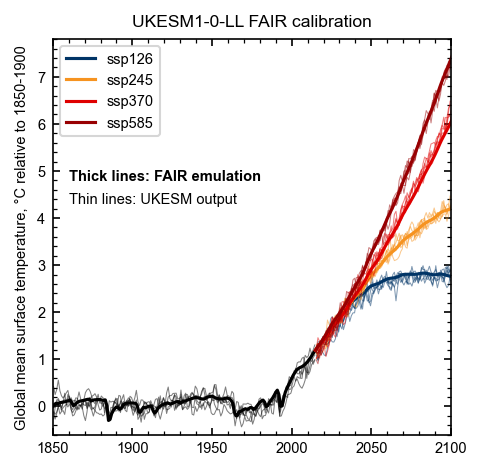

In [21]:
colors = ['#003466', '#f69320', '#df0000', '#980002']
pl.plot(np.arange(1850, 2016), f.temperature[:166, 0, 0, 0], color='k')
for ens in range(5):
    pl.plot(np.arange(1850.5, 2015), temp_ukesm[:165, 0, ens], lw=0.5, color='k', alpha=0.5)
for iscen, scenario in enumerate(scenarios):
    pl.plot(np.arange(2015, 2102), f.temperature[165:, iscen, 0, 0], color=colors[iscen], label=scenario)
    for ens in range(5):
        pl.plot(np.arange(2015.5, 2101), temp_ukesm[165:, iscen, ens], lw=0.5, color=colors[iscen], alpha=0.5)
pl.text(1860, 4.8, 'Thick lines: FAIR emulation', fontweight='bold')
pl.text(1860, 4.3, 'Thin lines: UKESM output')
pl.title('UKESM1-0-LL FAIR calibration')
pl.ylim(-0.6,7.8)
pl.xlim(1850, 2100)
pl.legend()
pl.ylabel('Global mean surface temperature, °C relative to 1850-1900')
pl.savefig('../plots/calibrated_coupled.png')

In [22]:
f.forcing_sum

<xarray.DataArray (timebounds: 252, scenario: 4, config: 1)> Size: 8kB
array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.24705485],
        [0.24705485],
        [0.24705485],
        [0.24705485]],

       [[0.22998663],
        [0.22998663],
        [0.22998663],
        [0.22998663]],

       ...,

       [[2.6890147 ],
        [4.4968315 ],
        [7.04806534],
        [8.70294897]],

       [[2.69052895],
        [4.51318339],
        [7.13263558],
        [8.80074578]],

       [[2.7083412 ],
        [4.54511195],
        [7.2332612 ],
        [8.91426624]]], shape=(252, 4, 1))
Coordinates:
  * timebounds  (timebounds) float64 2kB 1.85e+03 1.851e+03 ... 2.101e+03
  * scenario    (scenario) <U6 96B 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * config      (config) <U11 44B 'UKESM1-0-LL'

Text(0.5, 1.0, 'Difference between FAIR and UKESM')

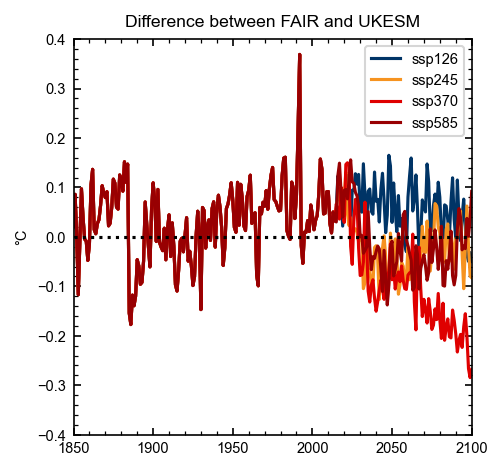

In [23]:
for iscen, scenario in enumerate(scenarios):
    pl.plot(np.arange(1850, 2101), f.temperature[:251, iscen, 0, 0] - temp_ukesm[:, iscen, :].mean(axis=1), color=colors[iscen], label=scenario)
pl.axhline(0, ls=":", color="k")
pl.legend()
pl.xlim(1850, 2100)
pl.ylim(-0.4, 0.4)
pl.ylabel('°C')
pl.title('Difference between FAIR and UKESM')

Text(0.5, 1.0, 'Effective radiative forcing in FAIR calibration')

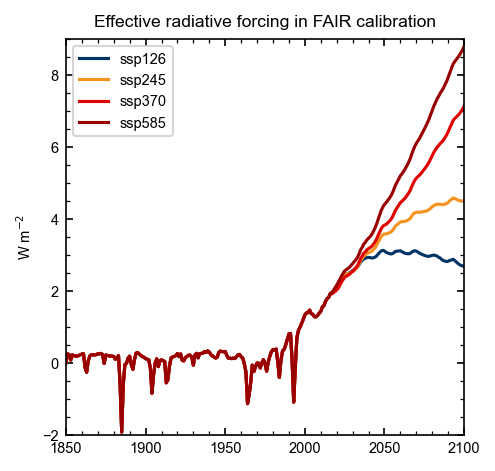

In [24]:
for iscen, scenario in enumerate(scenarios):
    pl.plot(np.arange(1850, 2102), f.forcing_sum[:, iscen, :], color=colors[iscen], label=scenario)
pl.legend()
pl.xlim(1850, 2100)
pl.ylim(-2, 9)
pl.ylabel('W m$^{-2}$')
pl.title('Effective radiative forcing in FAIR calibration')

In [25]:
f.forcing.sel(specie="Land use")

<xarray.DataArray (timebounds: 252, scenario: 4, config: 1)> Size: 8kB
array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.00055701],
        [-0.00055701],
        [-0.00055701],
        [-0.00055701]],

       [[-0.00110531],
        [-0.00110531],
        [-0.00110531],
        [-0.00110531]],

       ...,

       [[-0.15206705],
        [-0.16758574],
        [-0.25883627],
        [-0.21863813]],

       [[-0.15121476],
        [-0.16614838],
        [-0.25963696],
        [-0.21820653]],

       [[-0.15033783],
        [-0.1646964 ],
        [-0.26044041],
        [-0.21774362]]], shape=(252, 4, 1))
Coordinates:
  * timebounds  (timebounds) float64 2kB 1.85e+03 1.851e+03 ... 2.101e+03
  * scenario    (scenario) <U6 96B 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * config      (config) <U11 44B 'UKESM1-0-LL'
    specie      <U43 172B 'Land use'

In [26]:
f.concentration.loc[dict(specie='CH4', timebounds=1850, scenario='ssp245')]

<xarray.DataArray (config: 1)> Size: 8B
array([808.23201497])
Coordinates:
    timebounds  float64 8B 1.85e+03
    scenario    <U6 24B 'ssp245'
  * config      (config) <U11 44B 'UKESM1-0-LL'
    specie      <U43 172B 'CH4'

In [27]:
f.concentration.loc[dict(specie='CO2', timebounds=1850, scenario='ssp245')]

<xarray.DataArray (config: 1)> Size: 8B
array([284.26199849])
Coordinates:
    timebounds  float64 8B 1.85e+03
    scenario    <U6 24B 'ssp245'
  * config      (config) <U11 44B 'UKESM1-0-LL'
    specie      <U43 172B 'CO2'